In [1]:
# dependencies
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import keras_tuner
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("datasets/products.csv")

In [3]:
df = df.dropna(subset=["image_url", "rating"])
df = df[["image_url", "rating", "path"]]

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

In [5]:
# prepare the data

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
IMG_DIR = "images/amazon_images"

def fetch_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, IMG_SIZE) / 255.0  # since every pixel has values [0, 255], dividing by 255 normalizes them to [0, 1]

    return tf.cast(img, tf.float32), tf.cast(label, tf.float32)

def tf_fetch_image(url, label):
    img, lbl = tf.py_function(fetch_images, [url, label], [tf.float32, tf.float32])
    img.set_shape((*IMG_SIZE, 3))
    lbl.set_shape(())

    return img, lbl

def make_datasets(sub_dataframe):
    paths = [os.path.join(IMG_DIR, f"{name}.jpg") for name in sub_dataframe["path"]]
    ds = tf.data.Dataset.from_tensor_slices((paths, sub_dataframe["rating"].values))
    ds = ds.map(tf_fetch_image, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds, val_ds, test_ds = make_datasets(train_df), make_datasets(val_df), make_datasets(test_df)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(32, 128, 128, 3) [4.6 4.5 4.2 3.4 4.5 4.6 4.6 4.5 2.  4.4 1.9 4.3 4.5 3.9 3.3 5.  3.  4.4
 3.7 4.3 4.5 4.5 4.3 5.  4.5 4.3 4.7 4.7 4.6 4.4 4.5 3.6]


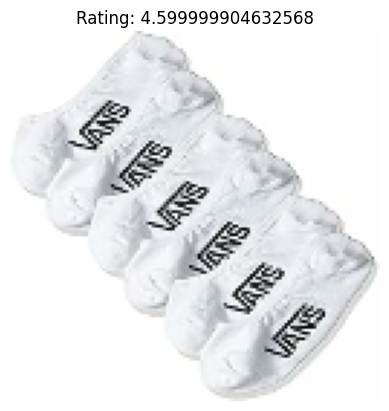

In [6]:
# here we can visualize the data (optional)

"""
the first for loop displays:

(32, 224, 224, 3) [3.3, ...., 1.5]

Here we have:
- a batch of 32 images
- 224x224 each (and their 3 respetive channels)
- [3.3, ..., 1.5] the array of ratings for each image
"""

for img, lbl in train_ds.take(1):
    print(img.shape, lbl.numpy())

"""
Second for loop shows the image
"""
for imgs, labels in train_ds.take(1):
    plt.imshow(imgs[0])        # show first image in the batch
    plt.title(f"Rating: {labels[0].numpy()}")
    plt.axis("off")
    plt.show()


In [7]:
def build_cnn_model(hp):

    model = tf.keras.Sequential()

    # input layer for images
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))

    # hyperparameter: number of conv layers, 1–3
    for i in range(hp.Int("num_conv_layers", 2, 4)):

        model.add(tf.keras.layers.Conv2D(
            filters = hp.Int(f"filters_{i}", min_value = 32, max_value = 128, step = 32),
            kernel_size = hp.Choice("kernel_size", values = [3]),
            activation = "relu",
            padding = "same"
        ))
        model.add(tf.keras.layers.Dropout(
        rate=hp.Float(f"dropout_conv_{i}", min_value=0.1, max_value=0.4, step=0.1)
        ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # global average pooling to connect with dense layers
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # hyperparameter: number of dense layers, 0–2
    for j in range(hp.Int("num_dense_layers", 1, 2)):
        model.add(tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{j}", min_value = 64, max_value = 128, step = 64),
            activation = hp.Choice("activation", ["relu"])
        ))

    
    # dropout after dense layers
    model.add(tf.keras.layers.Dropout(
        rate=hp.Float(f"dropout_dense_{j}", min_value=0.2, max_value=0.5, step=0.1)
    ))

    # output layer (regression on rating)
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # hyperparameter: learning rate
    hp_lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss = "mse",
        metrics = ["mae"]
    )

    return model


In [8]:
build_cnn_model(keras_tuner.HyperParameters())

<Sequential name=sequential, built=True>

In [9]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_cnn_model,
    objective = "val_mae",
    max_trials = 10,
    directory = "my_dir",
    project_name = "cnn_tuning",
    overwrite = True
)

tuner.search_space_summary()

Search space summary
Default search space size: 11
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
dropout_conv_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_conv_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': '

In [10]:
tuner.search(
    train_ds,
    validation_data = val_ds,
    epochs = 5
)

Trial 10 Complete [00h 12m 51s]
val_mae: 1.4870920181274414

Best val_mae So Far: 0.4633098840713501
Total elapsed time: 06h 55m 05s


In [11]:
tuner.results_summary()

Results summary
Results in my_dir\cnn_tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 02 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 128
kernel_size: 3
dropout_conv_0: 0.2
filters_1: 64
dropout_conv_1: 0.30000000000000004
num_dense_layers: 2
units_dense_0: 64
activation: relu
dropout_dense_0: 0.30000000000000004
learning_rate: 0.01
filters_2: 32
dropout_conv_2: 0.2
filters_3: 128
dropout_conv_3: 0.4
units_dense_1: 128
dropout_dense_1: 0.4
Score: 0.4633098840713501

Trial 01 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 96
kernel_size: 3
dropout_conv_0: 0.30000000000000004
filters_1: 96
dropout_conv_1: 0.30000000000000004
num_dense_layers: 2
units_dense_0: 64
activation: relu
dropout_dense_0: 0.4
learning_rate: 0.01
filters_2: 96
dropout_conv_2: 0.4
filters_3: 64
dropout_conv_3: 0.4
units_dense_1: 64
dropout_dense_1: 0.2
Score: 0.7298463582992554

Trial 06 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 32
kernel_size: 3
dropout

In [12]:
# best model
best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()

d:\My Stuff\Python\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,985 (351.50 KB)

 Trainable params: 89,985 (351.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Gather true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 